In [1]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np

print(tf.__version__)

/Users/yuchenshen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 1s 0us/step


In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


评论文本已转换为整数数组，每个整数表示字典中的特定单词。以下是第一篇评论文本转换后的形式：

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


电影评论的长度可能不同，但是神经网络的输入必须是相同长度，因此我们需要稍后解决此问题。以下代码显示了第一篇评论和第二篇评论分别包含的单词数量：



In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

将整数转换回单词：


In [6]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


In [8]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

在输入到神经网络之前，整数数组形式的评论必须转换为张量。这种转换可以通过以下两种方式完成：

 方法一：对数组进行独热编码（One-hot-encode），将其转换为0和1的向量。例如序列[3,5]将成为一个10,000维的向量，除索引3和5为1外，其余全部为零。然后，将其作为我们网络中的第一层——全连接层（稠密层，Dense layer）——以处理浮点向量数据。然而，这种方法会占用大量内存，需要一个num_words * num_reviews大小的矩阵。
 
方法二：填充数组，使它们都具有相同的长度，然后创建一个形状为max_length * num_reviews的整数张量。我们可以使用能够处理这种形状的嵌入层（embedding layer）作为我们神经网络中的第一层。

在本教程中，我们使用第二种方法。
由于电影评论的长度必须相同，我们使用pad_sequences函数对长度进行标准化：

In [9]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [10]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [12]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

神经网络是由层的叠加来实现的，因此我们需要做两个架构性决策：

模型中要使用多少层？
每层要使用多少隐藏单元？

在本例中，输入数据由单词索引数组组成，要预测的标签不是0就是1。我们可以建立这样一个模型来解决这个问题：

In [13]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


第一层是嵌入层（Embedding layer）。该层采用整数编码的词汇表，并查找每个词索引的嵌入向量。这些向量是作为模型训练学习的。向量为输出数组添加维度，生成的维度为：(batch, sequence, embedding)。

接下来，全局平均池化层（GlobalAveragePooling1D layer）通过对序列维度求平均，为每个评论返回固定长度的输出向量。这允许模型以最简单的方式处理可变长度的输入。

这个固定长度的输出向量通过一个带有16个隐藏单元的全连接层（稠密层，Dense layer）进行传输。

最后一层与单个输出节点紧密连接。使用sigmoid激活函数，输出值是介于0和1之间的浮点数，表示概率或置信水平。

In [14]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 40us/step - loss: 0.6915 - acc: 0.6131 - val_loss: 0.6888 - val_acc: 0.6752
Epoch 2/40
15000/15000 [==============================] - 0s 20us/step - loss: 0.6828 - acc: 0.7229 - val_loss: 0.6764 - val_acc: 0.7520
Epoch 3/40
15000/15000 [==============================] - 0s 19us/step - loss: 0.6648 - acc: 0.7744 - val_loss: 0.6549 - val_acc: 0.7688
Epoch 4/40
15000/15000 [==============================] - 0s 22us/step - loss: 0.6354 - acc: 0.7819 - val_loss: 0.6234 - val_acc: 0.7801
Epoch 5/40
15000/15000 [==============================] - 0s 21us/step - loss: 0.5952 - acc: 0.8082 - val_loss: 0.5818 - val_acc: 0.7980
Epoch 6/40
15000/15000 [==============================] - 0s 19us/step - loss: 0.5475 - acc: 0.8248 - val_loss: 0.5373 - val_acc: 0.8110
Epoch 7/40
15000/15000 [==============================] - 0s 20us/step - loss: 0.4974 - acc: 0.8433 - val_loss: 0.4928 - val_acc

In [17]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 0s 14us/step
[0.33694223010063173, 0.87264]


In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

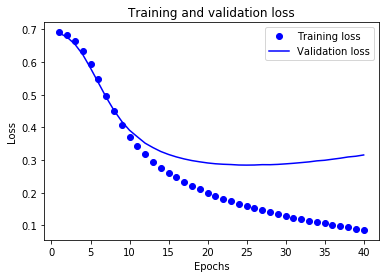

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

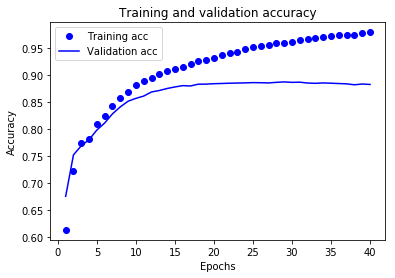

In [20]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()